# Generative Adversarial Networks (GANs)

Author: https://www.github.com/deburky

Generative Adversarial Networks (GANs) are a class of artificial intelligence algorithms used in unsupervised machine learning, implemented by a system of two neural networks contesting with each other in a zero-sum game framework. They were introduced by Ian Goodfellow et al. in 2014.

* Consists of two neural networks: a generator and a discriminator.
* The generator generates new data instances, while the discriminator evaluates them for authenticity.
* The generator is trained to fool the discriminator, and the discriminator is trained to recognize the generated data as fake.

Reference implementations
---
PyTorch GAN: [PyTorch GANs](https://github.com/eriklindernoren/PyTorch-GAN)

PyTorch Lightning GAN: [PyTorch Lightning Basic GAN Tutorial](https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/basic-gan.html)

## Convolutional GAN (DCGAN)

A Deep Convolutional Generative Adversarial Network (DCGAN) is a type of GAN that uses convolutional layers in the discriminator and generator. This allows the model to learn more complex features and generate more realistic images.

We leverage label smoothing to improve the performance of the discriminator. Label smoothing is a regularization technique that involves replacing the hard 0 and 1 labels with softer values, such as 0.9 and 0.1. This helps prevent the discriminator from becoming overconfident and improves the stability of the GAN training process.


We use device `mps`, which is MPS (Metal Performance Shaders) backend in Python. Metal is Apple’s API for programming metal GPU (graphics processor unit). Using MPS means that increased performance can be achieved, by running work on the metal GPU(s).

- Iris dataset Source: [Iris Computer Vision Dataset](https://www.kaggle.com/datasets/jeffheaton/iris-computer-vision)

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

torch.manual_seed(0)

batch_size = 8
num_workers = 4

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Path to the dataset
data_path = './data/fisher-iris-mini'

# Load the dataset
dataset = datasets.ImageFolder(root=data_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

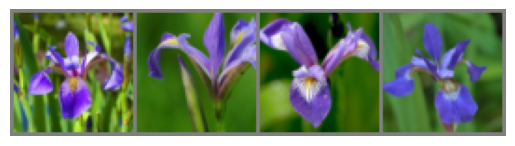

In [2]:
import torchvision
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Define the subset size
subset_size = int(1.0 * len(dataset))
indices = np.random.choice(len(dataset), subset_size, replace=True)
subset = Subset(dataset, indices)

# Create a DataLoader for the subset
data_loader = DataLoader(
    subset,
    batch_size=batch_size,
    num_workers=num_workers,
    persistent_workers=True,
    shuffle=True
)

# Get a batch of images
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))

In [3]:
%%time
import gc
import os
import time
import uuid

import chime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils


def save_image_with_custom_dpi(generated_images, epoch, save_path, nrow=8,dpi=600):
    """Function to save images with custom DPI"""
    grid_img = vutils.make_grid(generated_images.cpu(), nrow=nrow, normalize=True, pad_value=1.0).permute(1, 2, 0).numpy()
    fig, ax = plt.subplots(figsize=(6, 8))
    ax.set_title(f"Generator Output at Epoch {epoch + 1}", fontsize=14, fontname='Arial')
    ax.axis('off')
    ax.imshow(grid_img)
    plt.savefig(save_path, format='png', dpi=dpi, bbox_inches='tight', pad_inches=0.5)
    plt.close()

# Experiment name
strftime = time.strftime("%Y-%m-%d_%H-%M-%S")
id_str = uuid.uuid4().hex
run_id = id_str[:10] + id_str[-10:]
run_name = f"run-id-{run_id}-{strftime}"

# Initialize device for MPS
device = torch.device("mps")
torch.mps.manual_seed(0)
torch.mps.set_per_process_memory_fraction(0.5)
torch.backends.mps.allow_tf32 = True

# Set parameters
latent_dim = 1024
n_disc_maps = 128
n_output_images = 18
img_shape = (3, 64, 64)
num_epochs = 4_000
save_every_epoch = 100
lr_g = 2e-4
lr_d = 2e-4
real_label = .95
fake_label = .05

# Create a directory for saving images
dir_to_save =f"gan_training_images_fisher_iris/{run_name}"
os.makedirs(dir_to_save, exist_ok=True)

artifacts_dir = f"gan_training_artifacts_fisher_iris/{run_name}"
os.makedirs(artifacts_dir, exist_ok=True)

logs_dir = "gan_training_logs_fisher_iris"
log_name = f"log-{run_name}.txt"
os.makedirs(logs_dir, exist_ok=True)

# Write parameters to log file
with open(f"{logs_dir}/{log_name}", "w") as f:
    f.write(f"Run Name: {run_name}\n\n\n")
    f.write(f"Device: {device}\n")
    f.write(f"Batch size: {batch_size}\n")
    f.write(f"Number of Workers: {num_workers}\n")
    f.write(f"Latent Dimension: {latent_dim}\n")
    f.write(f"Number of Discriminator Maps: {n_disc_maps}\n")
    f.write(f"Number of Output Images: {n_output_images}\n")
    f.write(f"Image Shape: {img_shape}\n")
    f.write(f"Number of Epochs: {num_epochs}\n")
    f.write(f"Generator Learning Rate: {lr_g}\n")
    f.write(f"Discriminator Learning Rate: {lr_d}\n")
    f.write(f"Real Label: {real_label}\n")
    f.write(f"Fake Label: {fake_label}\n\n\n")


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection


class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.res_block1 = ResidualBlock(512)
        
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.res_block2 = ResidualBlock(256)
        
        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.res_block3 = ResidualBlock(128)
        
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.res_block4 = ResidualBlock(64)
        
        self.final = nn.Sequential(
            nn.ConvTranspose2d(64, img_shape[0], kernel_size=4, stride=2, padding=1, bias=True),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), latent_dim, 1, 1)
        x = self.initial(z)
        x = self.res_block1(x)  # Add residual block 1
        x = self.block2(x)
        x = self.res_block2(x)  # Add residual block 2
        x = self.block3(x)
        x = self.res_block3(x)  # Add residual block 3
        x = self.block4(x)
        x = self.res_block4(x)  # Add residual block 4
        return self.final(x)


# Define Discriminator model
class Discriminator(nn.Module):
    def __init__(self, n_disc_maps):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            torch.nn.utils.spectral_norm(nn.Conv2d(3, n_disc_maps, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(n_disc_maps, n_disc_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_disc_maps * 2),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(n_disc_maps * 2, n_disc_maps * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_disc_maps * 4),
            nn.LeakyReLU(0.01, inplace=True),       
            nn.Conv2d(n_disc_maps * 4, n_disc_maps * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_disc_maps * 8),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(n_disc_maps * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1)


# Initialize models and move to device
generator = Generator(latent_dim).to(device)
discriminator = Discriminator(n_disc_maps).to(device)

# Loss and optimizers
adversarial_loss = nn.BCELoss().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

# Start MPS-specific profiling
torch.mps.profiler.stop()
torch.mps.profiler.start()

# Run Caffeinate
os.system("caffeinate -ims &")

print(f"Starting Training...{run_name}")

for epoch in range(num_epochs):
    for imgs, _ in data_loader:
        imgs = imgs.to(device)

        # Label smoothing
        real_labels = torch.ones((imgs.size(0), 1), device=device, requires_grad=False) * real_label
        real_labels += .05 * torch.rand(real_labels.size(), device=device)
        fake_labels = torch.ones((imgs.size(0), 1), device=device, requires_grad=False) * fake_label
        fake_labels -= .05 * torch.rand(fake_labels.size(), device=device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(imgs), real_labels)
        
        z = torch.randn(imgs.size(0), latent_dim, 1, 1, device=device)
        gen_imgs = generator(z)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(gen_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        print(f"Epoch [{epoch + 1}/{num_epochs}] \t Real Loss: {real_loss:.4f} \t G Loss: {g_loss.item():.4f} \t D Loss: {d_loss.item():.4f}")
        
        # write to log file
        with open(f"{logs_dir}/{log_name}", "a") as f:
            f.write(f"Epoch [{epoch + 1}/{num_epochs}] \t Real Loss: {real_loss:.4f} \t G Loss: {g_loss.item():.4f} \t D Loss: {d_loss.item():.4f}\n")

    # Save model and images at intervals
    if (epoch + 1) % save_every_epoch == 0:
        torch.save(generator.state_dict(), f"{artifacts_dir}/generator_epoch_{epoch + 1}.pth")

        fixed_noise = torch.randn(n_output_images, latent_dim, 1, 1, device=device)
        with torch.no_grad():
            generated_images = generator(fixed_noise)
        save_path = f"{dir_to_save}/epoch_{epoch + 1}.png"
        save_image_with_custom_dpi(generated_images.cpu(), epoch=epoch, save_path=save_path, nrow=6, dpi=300)
        print(f"Saved generated images to {save_path}")

    del imgs, real_labels, fake_labels, real_loss, fake_loss, d_loss, gen_imgs
    gc.collect()
    
    if device in {'mps'}:
        torch.mps.empty_cache()

# Stop MPS-specific profiling
torch.mps.profiler.stop()
chime.theme('big-sur')
chime.success()

# Stop Caffeinate
_ = os.system("killall caffeinate")

Starting Training...run-id-235460331bcf77a38251-2024-10-21_22-20-35
Epoch [1/4000] 	 Real Loss: 0.7548 	 G Loss: 9.3448 	 D Loss: 0.7203
Epoch [1/4000] 	 Real Loss: 0.3949 	 G Loss: 6.6477 	 D Loss: 0.3597
Epoch [1/4000] 	 Real Loss: 0.4731 	 G Loss: 11.8522 	 D Loss: 0.5371
Epoch [1/4000] 	 Real Loss: 0.5199 	 G Loss: 3.8198 	 D Loss: 0.3169
Epoch [2/4000] 	 Real Loss: 0.4936 	 G Loss: 6.9170 	 D Loss: 0.3689
Epoch [2/4000] 	 Real Loss: 0.1754 	 G Loss: 11.2692 	 D Loss: 0.2484
Epoch [2/4000] 	 Real Loss: 0.9003 	 G Loss: 5.4167 	 D Loss: 0.5092
Epoch [2/4000] 	 Real Loss: 0.2230 	 G Loss: 5.6493 	 D Loss: 0.1535
Epoch [3/4000] 	 Real Loss: 0.1622 	 G Loss: 14.5493 	 D Loss: 0.3110
Epoch [3/4000] 	 Real Loss: 0.2270 	 G Loss: 10.8064 	 D Loss: 0.2377
Epoch [3/4000] 	 Real Loss: 1.4026 	 G Loss: 2.1265 	 D Loss: 0.7910
Epoch [3/4000] 	 Real Loss: 0.1413 	 G Loss: 19.0194 	 D Loss: 1.6934
Epoch [4/4000] 	 Real Loss: 0.2029 	 G Loss: 15.4709 	 D Loss: 0.2249
Epoch [4/4000] 	 Real Loss: 0

In [4]:
import imageio
import os

image_files = [img for img in sorted(os.listdir(dir_to_save)) if img.endswith(".png")]
image_files = sorted(image_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
images = [imageio.v3.imread(f"{dir_to_save}/{img}") for img in image_files]

imageio.mimsave(f"{dir_to_save}/gif-{run_name}.gif", images, fps=5)

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_85790/3899539796.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(f"{arti

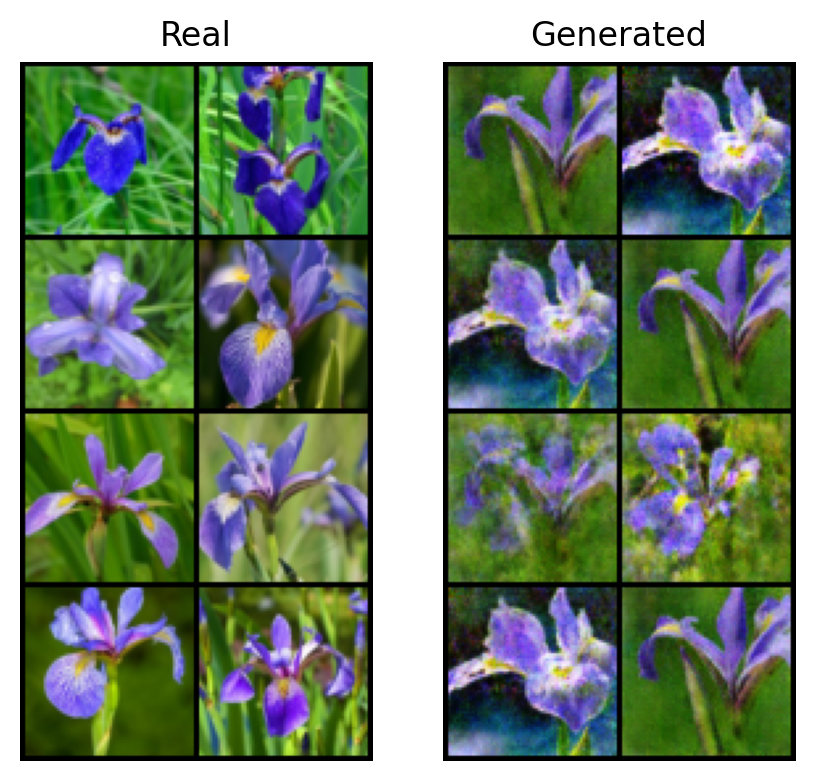

In [5]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
%config InlineBackend.figure_format = 'retina'

# Function to display real and generated images
def display_real_and_fake_images(real_images, fake_images, num_images=1):
    nrows = int(np.sqrt(num_images))
    plt.figure(figsize=(5, 5))

    # Real images
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real")
    plt.imshow(
        np.transpose(
            vutils.make_grid(
                real_images[:num_images], nrow=nrows, padding=2, normalize=True
            ).cpu(), (1, 2, 0)
        )
    )

    # Generated images
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Generated")
    plt.imshow(
        np.transpose(
            vutils.make_grid(
                fake_images[:num_images], nrow=nrows, padding=2, normalize=True
            ).cpu(), (1, 2, 0)
        )
    )
    plt.show()

# Load model with epoch number
epoch_number = 4_000
generator.load_state_dict(torch.load(f"{artifacts_dir}/generator_epoch_{epoch_number}.pth"))

# Generate new images with the trained generator using random noise each time
random_noise = torch.randn(64, latent_dim, 1, 1, device=device)
with torch.no_grad():
    generated_images = generator(random_noise)

# Obtain a batch of real images for comparison
real_batch = next(iter(data_loader))[0]

# Display real and generated images
display_real_and_fake_images(real_batch, generated_images, num_images=8)